In [2]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from speednav import utilities as util
import datetime
import networkx as nx
from scipy.sparse import csr_matrix
from networkx.algorithms import bipartite

In [3]:
# load the SPEED data
data = util.load_data()

# load the dictionary with the variable names and decriptions
data_vars  = util.DATA_VARS

### Filter data for country or other variable values

In [4]:
country_name = 'Liberia' # 'Sierra Leone', 'Philippines', 'Liberia' 
data_country = util.filter_data(data, country_name)
data_filter = data_country#.loc[(data_country.O0001 != 13)]

print(f"Total number of observations in {country_name}: " + str(len(data_filter)))

Total number of observations in Liberia: 2584


### create event-initiator matrix and edgelist

I am using the variable 'AEI0003' as index here as it is the unique ID of event.

In [6]:
# functions
def get_event_initiator_matrix(data_filter, initiator_columns):
    df = data_country[['AEI0003'] + initiator_columns] # select relevant columns
    df = df.set_index('AEI0003', drop = True) # reset index
    matrix =  pd.get_dummies(df, prefix='', prefix_sep='').groupby(level = 0, axis = 1).sum() # create matrix 
    matrix = matrix[matrix.sum(axis=1) > 0] # delete rows where rowsum = 0
    return matrix

def get_event_initiator_edgelist(matrix):
    edgelist = matrix.stack().reset_index() # convert from matrix to edgelist
    edgelist.columns = ['source', 'target', 'weight']
    edgelist = edgelist[edgelist['weight'] != 0] # delete rows where weight = 0
    edgelist = edgelist.reset_index(drop = True) 
    return edgelist


In [108]:
# get event_initiator matrix and edgelist
# initiator_columns = ['INI0005_1', 'INI0005_2', 'INI0005_3', 'INI0005_4', 'INI0005_5'] # person
initiator_columns = ['INI0011_1', 'INI0011_2', 'INI0011_3', 'INI0011_4', 'INI0011_5'] # group

matrix = get_event_initiator_matrix(data_filter, initiator_columns)
edgelist = get_event_initiator_edgelist(matrix)

### get the networks

In [109]:
# create bipartite network from the edgelist 
B = nx.from_pandas_edgelist(edgelist, 'source', 'target', edge_attr = True)


# get event vs initiator nodes
event_nodes = list(matrix.index)
initiator_nodes = list(matrix.columns.values)

# project to event or initiator networks
event_G = bipartite.weighted_projected_graph(B, event_nodes)
initiator_G = bipartite.weighted_projected_graph(B, initiator_nodes)


In [110]:
print("number of node in the event network: " + str(len(event_G.nodes())) +
      "; number of edges in the event network:", str(len(event_G.edges())))

print("number of node in the initiator network: " + str(len(initiator_G.nodes())) +
      "; number of edges in the initiator network:", str(len(initiator_G.edges())))


number of node in the event network: 418; number of edges in the event network: 32443
number of node in the initiator network: 39; number of edges in the initiator network: 5


### exploring the networks

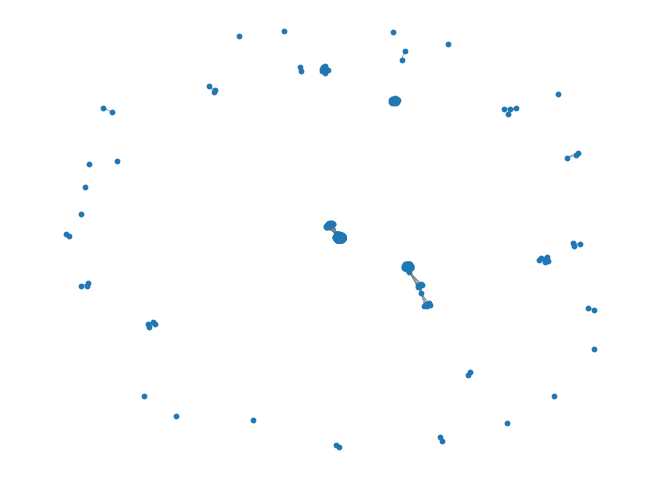

In [113]:
nx.draw(event_G, with_labels=False, node_size = 10, edge_color = 'grey', width = 0.5,
        pos = nx.spring_layout(event_G))

In [114]:
node_df = pd.DataFrame.from_records([i for i in event_G.degree()], columns=['node', 'degree'])

In [115]:
node_df['degree'].describe()

count    418.000000
mean     155.229665
std      111.038783
min        0.000000
25%       34.000000
50%      246.000000
75%      246.000000
max      274.000000
Name: degree, dtype: float64

In [116]:
node_df[node_df['degree'] >= 246]

,node,degree
100,230092,246
101,227043,246
102,227132,246
103,219937,246
104,227545,246
...,...,...
411,276755,246
412,269440,246
413,277685,274
414,281474,246


In [118]:
set(node_df[node_df['degree'] >= 246]['node']) - set(nx.neighbors(event_G, 227545))

{227545}

<Axes: >

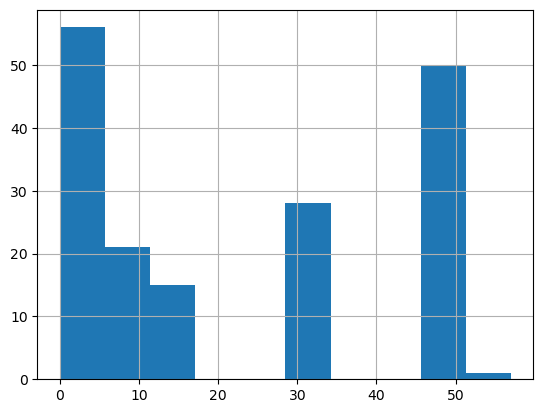

In [121]:
node_df[node_df['degree'] < 246]['degree'].hist()